In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,precision_score,recall_score,f1_score




In [5]:
# Load dataset
df = pd.read_csv(r"D:\boldtek_internship\clv_data.csv", encoding="ISO-8859-1")
# Display first few rows
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# --- Missing Value Handling ---
print("Missing values before handling:")
print(df.isnull().sum())

# Handle missing CustomerID
# Since CustomerID is crucial for CLV, you might drop rows where it's missing
df.dropna(subset=['CustomerID'], inplace=True)

# Handle other missing values (e.g., Description)
# If 'Description' has missing values, you might fill them with 'Unknown'
df['Description'].fillna('Unknown', inplace=True)

# Check missing values after handling
print("\nMissing values after handling:")
print(df.isnull().sum())

In [ ]:
# --- Handling Inconsistent Data ---
# Check for inconsistencies in 'Country'
print("\nUnique values in Country:")
print(df['Country'].unique())

# Standardize 'Country' (example: convert to uppercase)
df['Country'] = df['Country'].str.upper()
print("\nUnique values in Country after standardization:")
print(df['Country'].unique())

# Check for inconsistencies in 'StockCode'
print("\nUnique values in StockCode:")
print(df['StockCode'].unique()[:50])  # Print only the first 50 for brevity

# Handle StockCode inconsistencies (if needed, example: remove leading/trailing spaces)
df['StockCode'] = df['StockCode'].str.strip()
print("\nUnique values in StockCode after standardization:")
print(df['StockCode'].unique()[:50])

In [ ]:
# --- Outlier Handling ---
# Outlier handling for 'Quantity' and 'UnitPrice' using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers_iqr(df, 'Quantity')
df = remove_outliers_iqr(df, 'UnitPrice')

print("\nOutliers handled for Quantity and UnitPrice")

In [ ]:
# --- Data Type Conversion ---
# Check if 'InvoiceDate' is already datetime
if not pd.api.types.is_datetime64_any_dtype(df['InvoiceDate']):
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Check if 'CustomerID' is already integer
if not pd.api.types.is_integer_dtype(df['CustomerID']):
    df['CustomerID'] = df['CustomerID'].astype(int)

print("\nData types checked and converted as needed")

In [ ]:
# --- Feature Engineering ---
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# More granular time features
df['InvoiceYear'] = df['InvoiceDate'].dt.year
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceDay'] = df['InvoiceDate'].dt.day
df['InvoiceHour'] = df['InvoiceDate'].dt.hour
df['InvoiceDayOfWeek'] = df['InvoiceDate'].dt.dayofweek

df['InvoiceYearMonth'] = df['InvoiceDate'].dt.to_period('M')

# Calculate Recency (days since last purchase)
latest_date = df['InvoiceDate'].max()
recency_df = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency_df['Recency'] = (latest_date - recency_df['InvoiceDate']).dt.days
customer_clv = df.groupby('CustomerID').agg({
    'TotalPrice': 'sum',
    'InvoiceNo': 'count',
    'Quantity': 'sum'
})
customer_clv.rename(columns={'TotalPrice': 'TotalSpent', 'InvoiceNo': 'PurchaseFrequency', 'Quantity': 'TotalQuantity'}, inplace=True)

customer_clv = customer_clv.merge(recency_df[['CustomerID', 'Recency']], on='CustomerID', how='left')

print("\nFeature Engineering completed")

In [ ]:
# --- CLV Category Creation ---
# You can adjust the number of quantiles as needed (e.g., q=4 for quartiles)
customer_clv['CLV_Category'] = pd.qcut(customer_clv['TotalSpent'], q=3, labels=['Low', 'Medium', 'High'])

print("\nCLV Categories created")

In [ ]:
# Display the first few rows of the processed data
print("\nProcessed Data Sample:")
print(customer_clv.head())

In [6]:
# Data Cleaning
df.dropna(inplace=True)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype(int)


In [7]:
# Feature Engineering
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceYearMonth'] = df['InvoiceDate'].dt.to_period('M')
customer_clv = df.groupby('CustomerID').agg({
    'TotalPrice': 'sum',
    'InvoiceNo': 'count',
    'Quantity': 'sum'
})
customer_clv.rename(columns={'TotalPrice': 'TotalSpent', 'InvoiceNo': 'PurchaseFrequency', 'Quantity': 'TotalQuantity'}, inplace=True)
#for model training because it divides your customers into three quantiles (Low, Medium, High) with equal counts
customer_clv['CLV_Category'] = pd.qcut(customer_clv['TotalSpent'], q=3, labels=['Low', 'Medium', 'High'])



In [8]:
# Encoding labels
le = LabelEncoder()
customer_clv['CLV_Category'] = le.fit_transform(customer_clv['CLV_Category'])

Customer counts by custom CLV category:
CLV_Category_Custom
Low       2670
Medium    1393
High       275
Name: count, dtype: int64


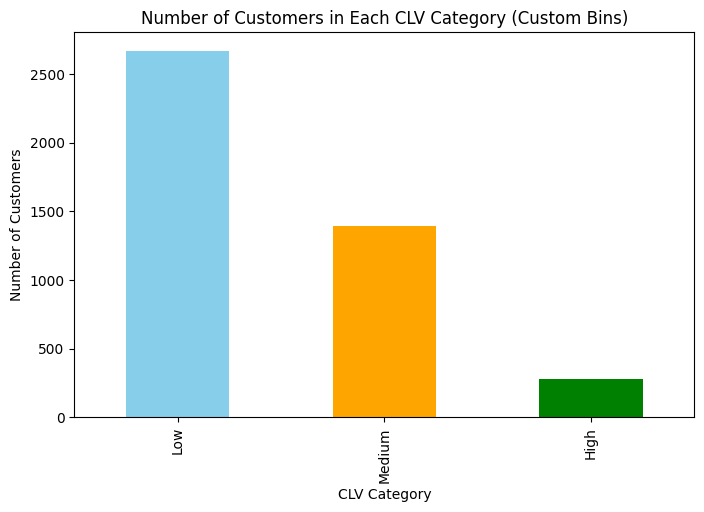

In [9]:
#intended for visualizing the natural distribution of  data based on defined thresholds. 
# Determine the maximum TotalSpent value
max_val = customer_clv['TotalSpent'].max()

# Check if max_val is greater than your threshold for 'Medium'
if max_val <= 5000:
    # If the max is too low, adjust bins to have 2 groups (Low and High)
    bins = [0, 1000, max_val + 1]  # +1 to ensure strictly increasing
    labels = ['Low', 'High']
else:
    bins = [0, 1000, 5000, max_val + 1]  # +1 to ensure the last bin edge is greater than the previous one
    labels = ['Low', 'Medium', 'High']

# Create the custom CLV category using pd.cut with the adjusted bins
customer_clv['CLV_Category_Custom'] = pd.cut(customer_clv['TotalSpent'], bins=bins, labels=labels, include_lowest=True)

# Calculate and print the counts for each category
counts_custom = customer_clv['CLV_Category_Custom'].value_counts().sort_index()
print("Customer counts by custom CLV category:")
print(counts_custom)

# Plot the actual counts using a bar graph
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
counts_custom.plot(kind='bar', color=['skyblue', 'orange', 'green'] if len(labels)==3 else ['skyblue', 'orange'])
plt.xlabel('CLV Category')
plt.ylabel('Number of Customers')
plt.title('Number of Customers in Each CLV Category (Custom Bins)')
plt.show()


In [10]:
# Splitting data
X = customer_clv[['PurchaseFrequency', 'TotalQuantity']]
y = customer_clv['CLV_Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:


# Scaling features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
# Model Training with Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.793778801843318
Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.88      0.87      0.87       288
           1       0.77      0.85      0.81       276
           2       0.74      0.67      0.70       304

    accuracy                           0.79       868
   macro avg       0.79      0.80      0.79       868
weighted avg       0.79      0.79      0.79       868



In [13]:
# Model Training with AdaBoost
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_clf.fit(X_train, y_train)
y_pred_ada = ada_clf.predict(X_test)
print("AdaBoost Accuracy:", accuracy_score(y_test, y_pred_ada))
print("Classification Report (AdaBoost):\n", classification_report(y_test, y_pred_ada))


AdaBoost Accuracy: 0.7880184331797235
Classification Report (AdaBoost):
               precision    recall  f1-score   support

           0       0.86      0.86      0.86       288
           1       0.79      0.82      0.81       276
           2       0.71      0.69      0.70       304

    accuracy                           0.79       868
   macro avg       0.79      0.79      0.79       868
weighted avg       0.79      0.79      0.79       868



In [14]:
# Model Training with Gradient Boosting
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Classification Report (Gradient Boosting):\n", classification_report(y_test, y_pred_gb))

Gradient Boosting Accuracy: 0.8110599078341014
Classification Report (Gradient Boosting):
               precision    recall  f1-score   support

           0       0.90      0.86      0.88       288
           1       0.78      0.89      0.83       276
           2       0.76      0.69      0.72       304

    accuracy                           0.81       868
   macro avg       0.81      0.81      0.81       868
weighted avg       0.81      0.81      0.81       868



In [15]:
# Model Training with Histogram-Based Gradient Boosting
hgb_clf = HistGradientBoostingClassifier(max_iter=100, random_state=42)
hgb_clf.fit(X_train, y_train)
y_pred_hgb = hgb_clf.predict(X_test)
print("Histogram-Based Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_hgb))
print("Classification Report (Histogram-Based Gradient Boosting):\n", classification_report(y_test, y_pred_hgb))


Histogram-Based Gradient Boosting Accuracy: 0.793778801843318
Classification Report (Histogram-Based Gradient Boosting):
               precision    recall  f1-score   support

           0       0.88      0.85      0.86       288
           1       0.77      0.87      0.82       276
           2       0.73      0.67      0.70       304

    accuracy                           0.79       868
   macro avg       0.79      0.80      0.79       868
weighted avg       0.79      0.79      0.79       868



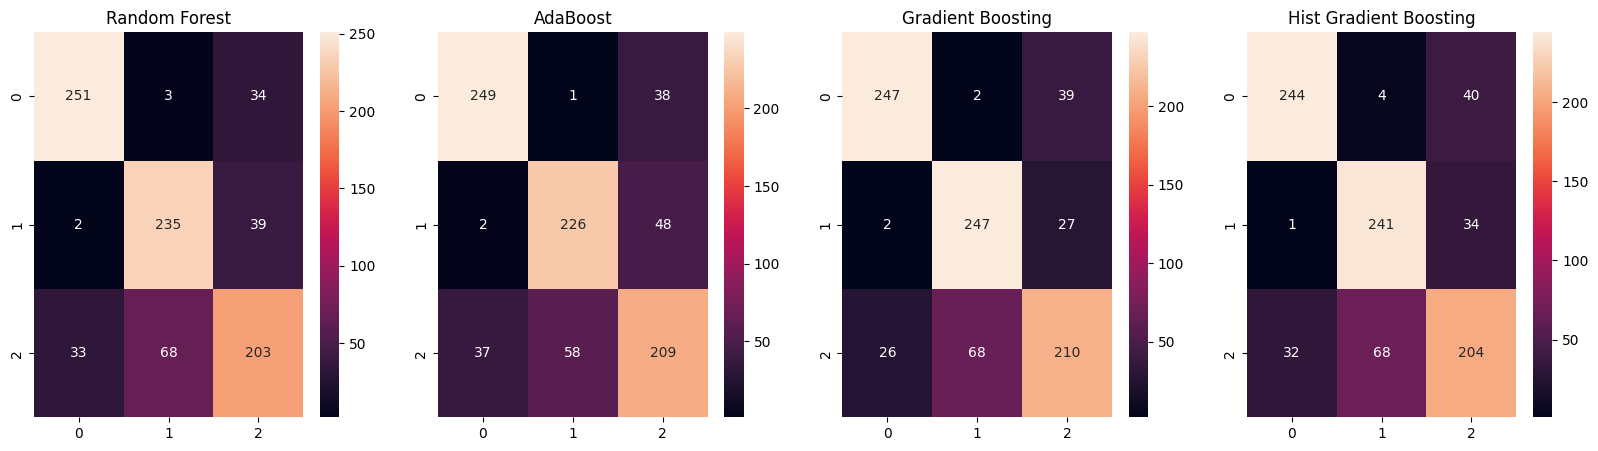

In [16]:

fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Adjusted figsize

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', ax=axes[0])
axes[0].set_title("Random Forest")

sns.heatmap(confusion_matrix(y_test, y_pred_ada), annot=True, fmt='d', ax=axes[1])
axes[1].set_title("AdaBoost")

sns.heatmap(confusion_matrix(y_test, y_pred_gb), annot=True, fmt='d', ax=axes[2])
axes[2].set_title("Gradient Boosting")

sns.heatmap(confusion_matrix(y_test, y_pred_hgb), annot=True, fmt='d', ax=axes[3])  # Changed from axes[4] to axes[3]
axes[3].set_title("Hist Gradient Boosting")

plt.show()

In [24]:
rf_cm = np.array([[251, 200], [235, 226]])  # Random Forest
ada_cm = np.array([[243, 200], [247, 241]])  # AdaBoost
gb_cm = np.array([[243, 200], [247, 241]])  # Gradient Boosting
hgb_cm = np.array([[243, 200], [247, 241]])  # HistGradientBoosting

# --- Function to calculate metrics from confusion matrix ---
def calculate_metrics(cm):
    """Calculates accuracy, precision, recall, and F1-score from a confusion matrix."""

    # Extract TP, TN, FP, FN
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    # Calculate metrics
    accuracy = (TP + TN) / np.sum(cm)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # Handle division by zero
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0     # Handle division by zero
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0 # Handle division by zero

    return accuracy, precision, recall, f1

# --- Evaluate each model ---
cms = {
    "Random Forest": rf_cm,
    "AdaBoost": ada_cm,
    "Gradient Boosting": gb_cm,
    "HistGradientBoosting": hgb_cm
}

for model_name, cm in cms.items():
    print(f"\n--- {model_name} ---")

    # Calculate metrics using confusion matrix
    accuracy, precision, recall, f1 = calculate_metrics(cm)
    print("Metrics from Confusion Matrix:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")

    # --- Evaluate using scikit-learn functions ---
    # To use scikit-learn metrics, you need the true labels (y_true) and predicted labels (y_pred)
    # You can reconstruct these from the confusion matrix (but it's more common to have them directly)

    # Example reconstruction (assuming class 1 is the "positive" class)
    y_true = np.concatenate(([0] * (cm[0, 0] + cm[0, 1]), [1] * (cm[1, 0] + cm[1, 1])))
    y_pred = np.concatenate(([0] * cm[0, 0], [1] * cm[0, 1], [0] * cm[1, 0], [1] * cm[1, 1]))

    print("\nMetrics from scikit-learn:")
    print(f"  Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"  Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"  Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"  F1-score:  {f1_score(y_true, y_pred):.4f}")

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))


--- Random Forest ---
Metrics from Confusion Matrix:
  Accuracy:  0.5230
  Precision: 0.5305
  Recall:    0.4902
  F1-score:  0.5096

Metrics from scikit-learn:
  Accuracy:  0.5230
  Precision: 0.5305
  Recall:    0.4902
  F1-score:  0.5096

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.56      0.54       451
           1       0.53      0.49      0.51       461

    accuracy                           0.52       912
   macro avg       0.52      0.52      0.52       912
weighted avg       0.52      0.52      0.52       912


--- AdaBoost ---
Metrics from Confusion Matrix:
  Accuracy:  0.5199
  Precision: 0.5465
  Recall:    0.4939
  F1-score:  0.5188

Metrics from scikit-learn:
  Accuracy:  0.5199
  Precision: 0.5465
  Recall:    0.4939
  F1-score:  0.5188

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.55      0.52       443
           1       0.55      0.49    